## Run the cells to generate charts for visualizing the benchmarks


### Original LayerSkip Visualizations

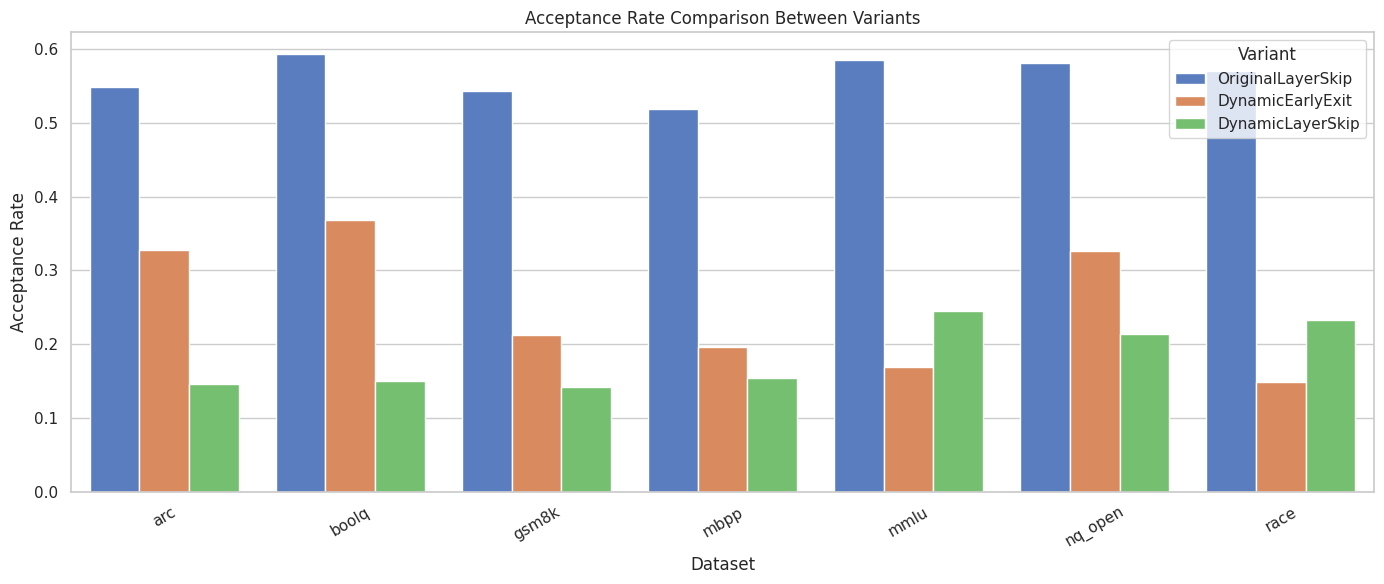

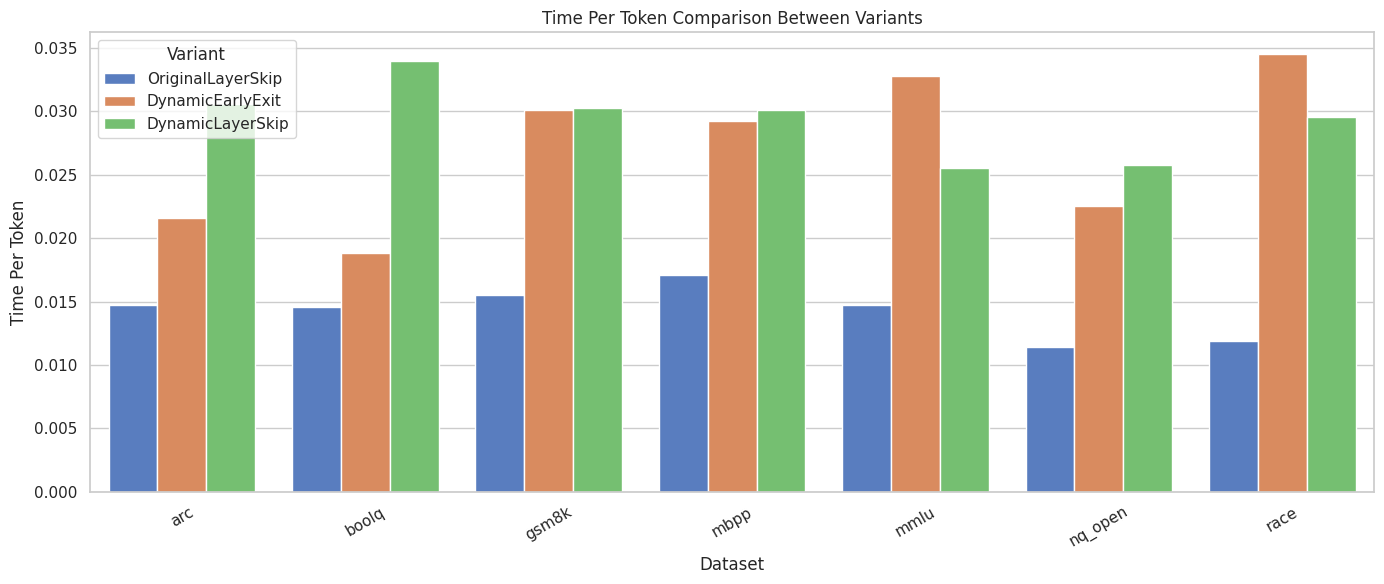

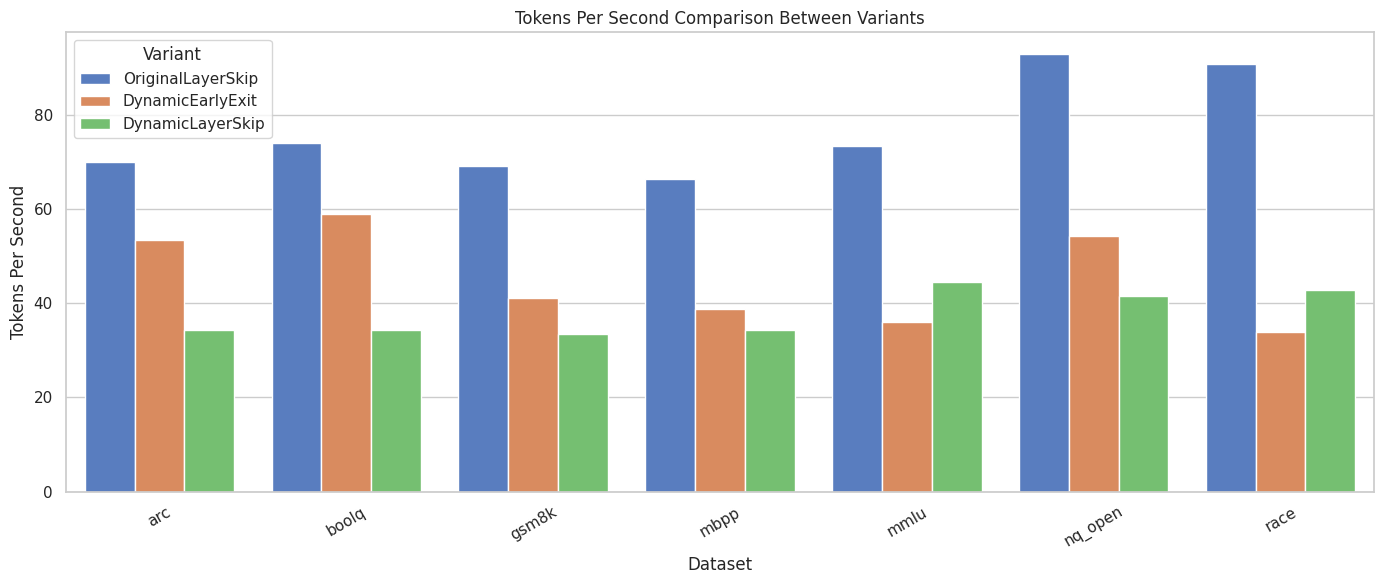

In [7]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the metrics you want to plot
metrics_to_plot = ["acceptance_rate", "time_per_token", "tokens_per_second"]

# Step 2: Function to load JSON files
def load_benchmarks(path_pattern, label):
    files = glob.glob(path_pattern)
    results = []
    
    for file_path in sorted(files):
        with open(file_path, 'r') as f:
            content = f.read()
        
        json_objects = re.findall(r'\{.*?\}(?=\{|\Z)', content, flags=re.DOTALL)
        parsed_data = [json.loads(obj) for obj in json_objects]
        
        metrics = parsed_data[-1]
        
        dataset_name = file_path.split('/')[-1].replace('.json', '')
        
        # Clean up dataset name: remove all unwanted suffixes
        dataset_name = dataset_name.replace('benchmark_', '')
        dataset_name = re.sub(r'_(original|dynamicearlyexit|non_finetuned_dynamic_layer_skip)$', '', dataset_name)

        result = {
            "dataset": dataset_name,
            "variant": label,
            "acceptance_rate": metrics["acceptance_rate"]["mean"],
            "time_per_token": metrics["time_per_token"]["mean"],
            "tokens_per_second": metrics["tokens_per_second"]["mean"],
        }
        results.append(result)
    
    return results

# Step 3: Load all three sets
original_results = load_benchmarks('OriginalLayerSkip/*.json', label='OriginalLayerSkip')
dynamic_early_exit_results = load_benchmarks('DynamicEarlyExit/*.json', label='DynamicEarlyExit')
dynamic_layer_skip_results = load_benchmarks('DynamicLayerSkip/*.json', label='DynamicLayerSkip')

# Combine into a single DataFrame
df = pd.DataFrame(original_results + dynamic_early_exit_results + dynamic_layer_skip_results)

# Step 4: Set plotting style
sns.set_theme(style="whitegrid")

# Step 5: Plot each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(14, 6))

    # Make sure datasets are sorted consistently
    order = sorted(df['dataset'].unique())

    sns.barplot(
        data=df, 
        x="dataset", 
        y=metric, 
        hue="variant", 
        order=order, 
        palette="muted"
    )

    plt.title(f'{metric.replace("_", " ").title()} Comparison Between Variants')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Dataset')
    plt.xticks(rotation=30)

    plt.legend(title="Variant")
    plt.tight_layout()
    plt.show()


### Pareto Curve for GSM8k


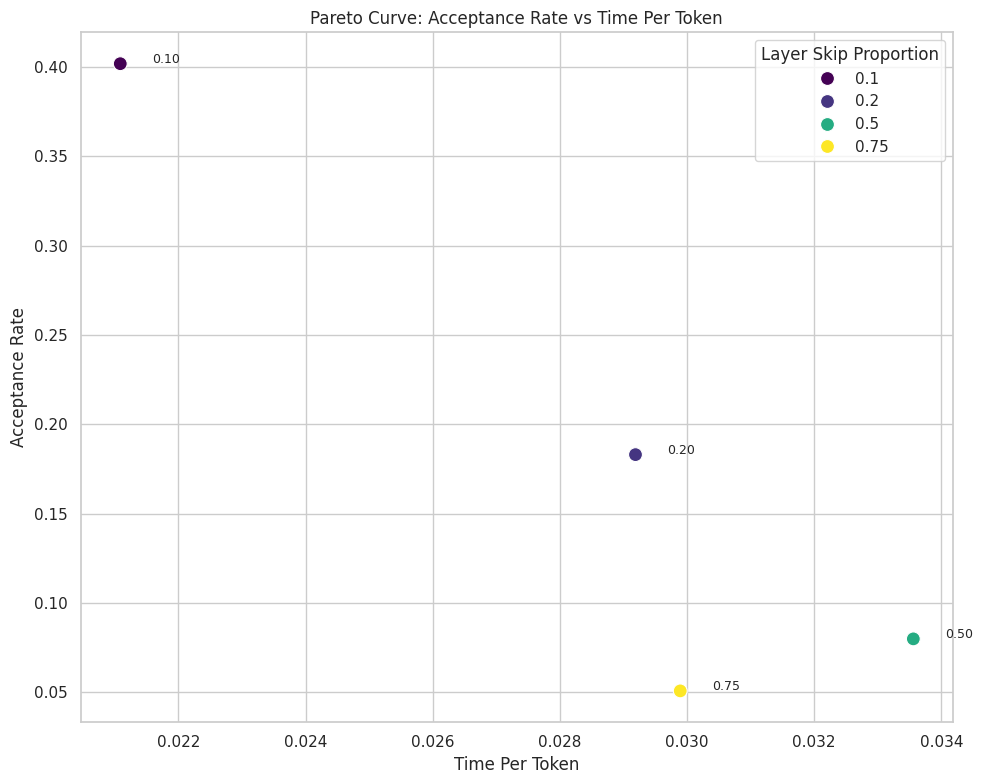

In [10]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

path_pattern = '/home/hice1/iju6/scratch/cs7643-project-skiplayer/LayerSkip/logs/DynamicLayerSkip_gs8mk/*.json'
files = glob.glob(path_pattern)

results = []

for file_path in sorted(files):
    with open(file_path, 'r') as f:
        content = f.read()

    json_objects = re.findall(r'\{.*?\}(?=\{|\Z)', content, flags=re.DOTALL)
    parsed_data = [json.loads(obj) for obj in json_objects]

    hyperparams = parsed_data[2]
    metrics = parsed_data[-1]

    result = {
        "dataset": file_path.split('/')[-1].replace('.json', '').replace('benchmark_', ''),
        "layer_skip_proportion": hyperparams.get("layer_skip_proportion", 0.0),
        "acceptance_rate": metrics["acceptance_rate"]["mean"],
        "time_per_token": metrics["time_per_token"]["mean"],
    }
    results.append(result)

df = pd.DataFrame(results)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))

x_metric = 'time_per_token'
y_metric = 'acceptance_rate'

scatter = sns.scatterplot(
    data=df,
    x=x_metric,
    y=y_metric,
    hue="layer_skip_proportion",
    palette="viridis",
    s=100,
    legend="full"
)

for i, row in df.iterrows():
    plt.text(
        row[x_metric] + 0.0005,
        row[y_metric] + 0.0005,
        f"{row['layer_skip_proportion']:.2f}",
        fontsize=9
    )

def pareto_front(df, x_col, y_col):
    """Return points on the Pareto front."""
    points = df[[x_col, y_col]].values
    points = points[np.argsort(points[:, 0])]

    pareto = [points[0]]
    for point in points[1:]:
        if point[1] > pareto[-1][1]:
            pareto.append(point)
    return np.array(pareto)

front = pareto_front(df, x_metric, y_metric)

plt.xlabel(x_metric.replace("_", " ").title())
plt.ylabel(y_metric.replace("_", " ").title())
plt.title(f"Pareto Curve: {y_metric.replace('_', ' ').title()} vs {x_metric.replace('_', ' ').title()}")
plt.legend(title="Layer Skip Proportion")
plt.grid(True)
plt.tight_layout()
plt.show()
